In [1]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib as mlp

from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

from models.fno import FNO3d
from models.lploss import LpLoss

In [2]:
dev = 'cpu'
# if torch.cuda.is_available(): 
#     dev = "cuda:0" 
# else: 
#     dev = "cpu" 
device = torch.device(dev) 

In [3]:
data_path = '/project/data/l63/'

In [4]:
# Data path
mesh_path = os.path.join(data_path, 'mesh.npy')
pdfn_path = os.path.join(data_path, 'post.npy')

# Read numpy matrices
mesh = torch.from_numpy(np.load(mesh_path).reshape((1, 40, 40, 40, 3)))
pdfn = torch.from_numpy(np.load(pdfn_path).reshape((-1, 40, 40, 40, 1)))

pdfn = pdfn[:166]
pdfn = pdfn.repeat((3, 1, 1, 1, 1))

In [5]:
pdf2d = pdfn.sum(dim=3).squeeze(-1)

# m, n = 3, 3
# ind = np.linspace(0, 198, m*n).astype(int).reshape((m, n))

# fig, ax = plt.subplots(m, n, figsize=(8, 10))

# for i in range(3):
#     for j in range(3):
#         ax[i, j].imshow(pdf2d[ind[i, j]])
#         ax[i, j].set_title(f'{ind[i, j]+1}')


In [6]:
# pdfflat = pdf2d.view(499, -1)
pdfmin = pdf2d.min() #pdfflat.min(-1).values.reshape(-1, 1, 1).repeat((1, 40, 40))
pdfmax = pdf2d.max() # pdfflat.max(-1).values.reshape(-1, 1, 1).repeat((1, 40, 40))
pdf2d = ((pdf2d - pdfmin)/(pdfmax - pdfmin))

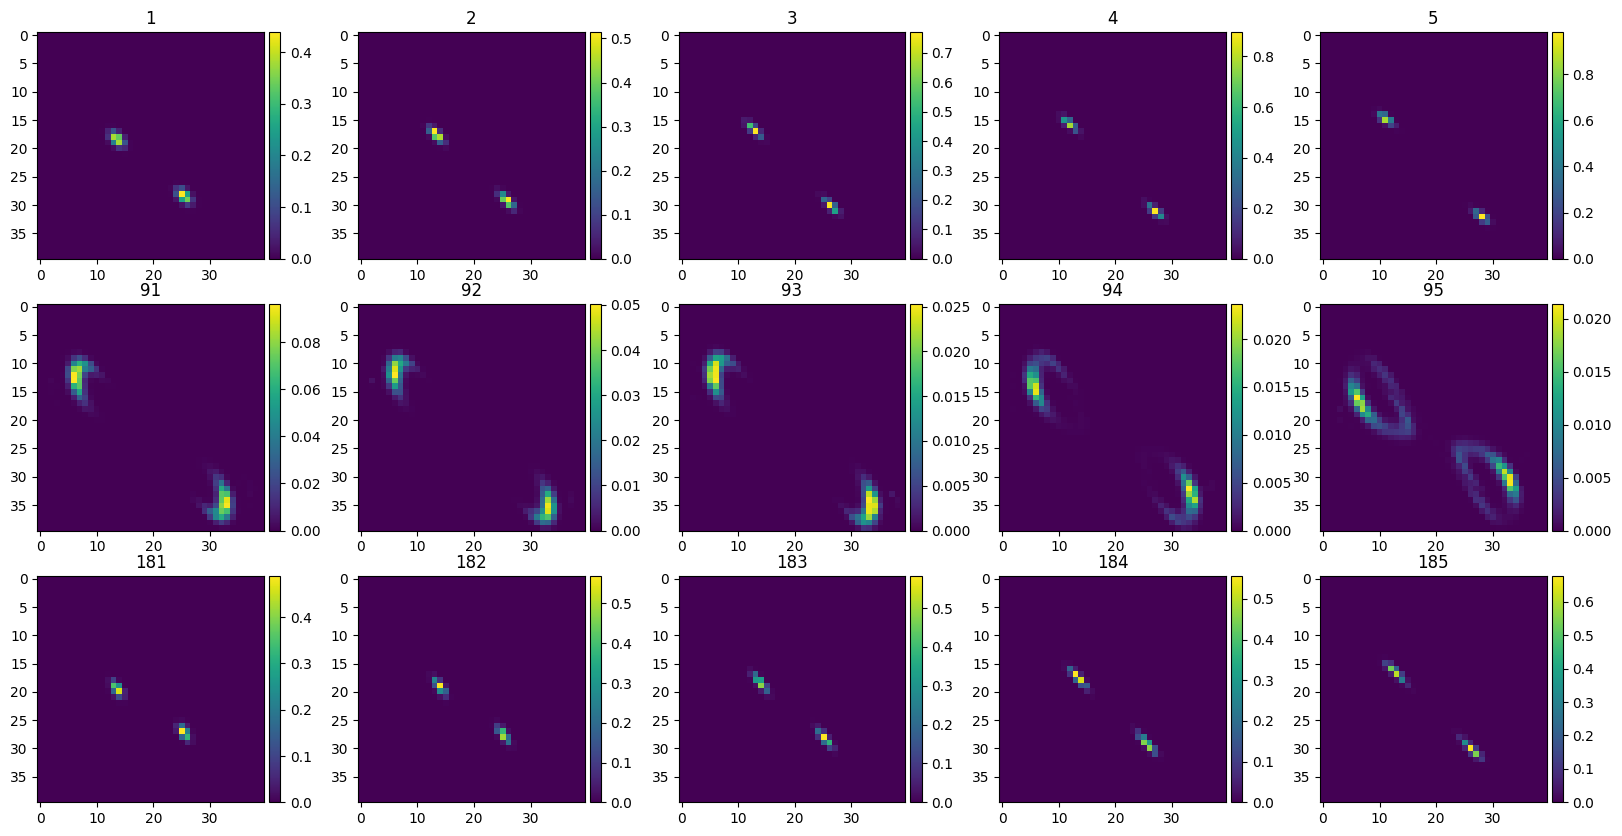

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

m, n = 3, 5
ind = np.linspace(0, 180, m).astype(int)

fig, ax = plt.subplots(m, n, figsize=(20,10))

for i in range(m):
    for j in range(n):
        im = ax[i, j].imshow(pdf2d[ind[i]+j])
        ax[i, j].set_title(f'{ind[i]+j+1}')

        divider = make_axes_locatable(ax[i, j])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

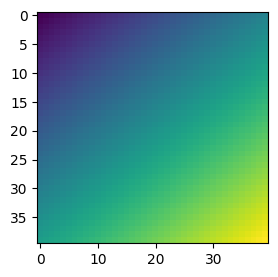

In [8]:
mesh2d = mesh.mean(-2)[...,:-1]
fig = plt.figure(figsize=(3, 3))
plt.imshow(mesh2d[0].sum(-1))

In [9]:
# h = 1e-3
# M = 40
# Tf = 20
# NT = int(Tf/h)
# ts = torch.linspace(0, 20, int(NT/M)).reshape(-1, 1, 1, 1)
# ts = ts.repeat(1, 40, 40, 1)

In [10]:
p = torch.concat([pdf2d.unsqueeze(-1), mesh2d.repeat(pdf2d.shape[0], 1, 1, 1)],
                 dim=-1)
p = torch.concat([p, p[-2:]], dim=0)
# p = torch.concat([p, ts], dim=-1)
p.shape

torch.Size([500, 40, 40, 3])

In [11]:
def get_dataset(p, n_steps=10):
    xs = []
    ys = []
    for i in range(0, p.shape[0]-2*n_steps):
        xs.append(p[i: i+n_steps])
        ys.append(p[i+n_steps:i+2*n_steps, ..., 0].unsqueeze(-1))
    x = torch.stack(xs, dim=0)
    y = torch.stack(ys, dim=0)
    return TensorDataset(x, y)

In [12]:
full_ds = get_dataset(p, n_steps=10)
train_size = int(0.7 * len(full_ds))
test_size = len(full_ds) - train_size
train_ds, test_ds = torch.utils.data.random_split(full_ds, 
                                                  [train_size, test_size])


In [13]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [14]:
epochs = 50
e_start = 0
learning_rate = 0.001
scheduler_step = 4
scheduler_gamma = 0.85
learning_rate

0.001

In [15]:
mode1 = 8
mode2 = 18
mode3 = 18
width = 128
n_blocks = 6

model = FNO3d(mode1, mode2, mode3, width, 
              n_blocks=n_blocks, in_channel=3, device=device)
model = model.to(device)

# for w in model.parameters():
#     torch.nn.init.normal_(w)


In [16]:
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                             step_size=scheduler_step, 
#                                             gamma=scheduler_gamma)
myloss = LpLoss(size_average=True)

In [17]:
for ep in range(1,epochs+1):
    model.train()
    train_l2 = 0
    test_l2 = 0
    counter = 0
    for x, y in train_dl:
        
        optimizer.zero_grad()

        x = x.to(device)
        y = y.to(device)
    
        pred = model(x)
        ori_loss = 0

        num_examples = x.shape[0]
        
        # original loss
        # for i in range(batch_size):
        ori_loss = myloss(pred.reshape(num_examples, -1), 
                           y.reshape(num_examples, -1))
        mse_loss = F.mse_loss(pred, y)
        loss = 0.8 * ori_loss + mse_loss
        
        loss.backward()
        optimizer.step()
        train_l2 += loss.item()

        counter += 1
        # if counter % 5 == 0:
        #     print(f'epoch: {ep}, batch: {counter}/{len(train_dl)}, train loss: {loss.item():.4f}')
    
    # scheduler.step()
    
    if ep % 2 == 0:
        
        model.eval()
        
        for x, y in test_dl:

            x = x.to(device)
            y = y.to(device)
        
        
            pred = model(x)
            ori_loss = 0

            num_examples = x.shape[0]
            ori_loss += myloss(pred.reshape(num_examples, -1), 
                            y.reshape(num_examples, -1))
            
            mse_loss = F.mse_loss(pred, y)
            loss = 0.8 * ori_loss + mse_loss

            test_l2 += loss.item()
        
        print(f'epoch: {ep}, train loss: {train_l2/len(train_dl):.4f}, test loss: {test_l2/len(test_dl):.4f}')
    
    else:
        print(f'epoch: {ep}, train loss: {train_l2/len(train_dl):.4f}')
    
    # lr_ = optimizer.param_groups[0]['lr']
    # if ep % 2 == 0:
    #     PATH = f'saved_models/dP_UFNO_{ep}ep_{width}width_{mode1}m1_{mode2}m2_{train_a.shape[0]}train_{lr_:.2e}lr'

    #     torch.save(model, PATH)

epoch: 1, train loss: 1.2450
epoch: 2, train loss: 0.8528, test loss: 0.7761
epoch: 3, train loss: 0.7831
epoch: 4, train loss: 0.7675, test loss: 0.7623
epoch: 5, train loss: 0.7632
epoch: 6, train loss: 0.7599, test loss: 0.7583
epoch: 7, train loss: 0.7572
epoch: 8, train loss: 0.7555, test loss: 0.7544
epoch: 9, train loss: 0.7533
epoch: 10, train loss: 0.7515, test loss: 0.7510
epoch: 11, train loss: 0.7502
epoch: 12, train loss: 0.7486, test loss: 0.7477
epoch: 13, train loss: 0.7470


In [1]:
ind = 0
a, p = full_ds[4]

fig, ax = plt.subplots(3, a.shape[0], figsize=(a.shape[0]*3,10))


for j in range(a.shape[0]):
    ax[0, j].imshow(a[j, ..., 0].cpu())
ax[0, 1].set_title("Input")


for j in range(a.shape[0]):
    ax[1, j].imshow(p[j, ..., 0].cpu())
ax[1, 1].set_title("Target")

pred = model(a.unsqueeze(0)).relu()[0].cpu().detach().numpy()

for j in range(a.shape[0]):
    ax[2, j].imshow(pred[j, ..., 0])

ax[2, 1].set_title("FNO")


NameError: name 'full_ds' is not defined